In [1]:
import openmc
import numpy as np
import tokamak_radiation_environment as tre

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [6]:
iter_sp = openmc.StatePoint("../reactors/iter_class/statepoint.045.h5")
arc_sp = openmc.StatePoint("../reactors/arc_class/statepoint.005.h5")

In [7]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)
arc_tfcoil_spectrum = arc_sp.get_tally(id=4)

iter_spectrum_mean = iter_tfcoil_spectrum.mean[:,0,0]
arc_spectrum_mean = arc_tfcoil_spectrum.mean[:,0,0]

iter_spectrum_stddev = iter_tfcoil_spectrum.std_dev[:,0,0]
arc_spectrum_stddev = arc_tfcoil_spectrum.std_dev[:,0,0]

ebins = iter_tfcoil_spectrum.filters[2].bins[:,0]

In [8]:
iter_gas_production = iter_sp.get_tally(id=3).get_pandas_dataframe()
arc_gas_production = arc_sp.get_tally(id=3).get_pandas_dataframe()

print(iter_gas_production)
print(arc_gas_production)

  mesh 3       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 9.74e-10  6.04e-11
1      1  1  1   total    (n,Xd) 3.15e-11  2.48e-12
2      1  1  1   total    (n,Xt) 8.19e-11  9.09e-13
3      1  1  1   total  (n,X3He) 1.08e-16  1.86e-17
4      1  1  1   total    (n,Xa) 1.29e-06  7.00e-09
  mesh 3       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 3.74e-08  6.53e-10
1      1  1  1   total    (n,Xd) 7.29e-10  1.51e-11
2      1  1  1   total    (n,Xt) 7.79e-10  7.29e-12
3      1  1  1   total  (n,X3He) 2.04e-14  8.08e-16
4      1  1  1   total    (n,Xa) 7.70e-06  1.05e-08


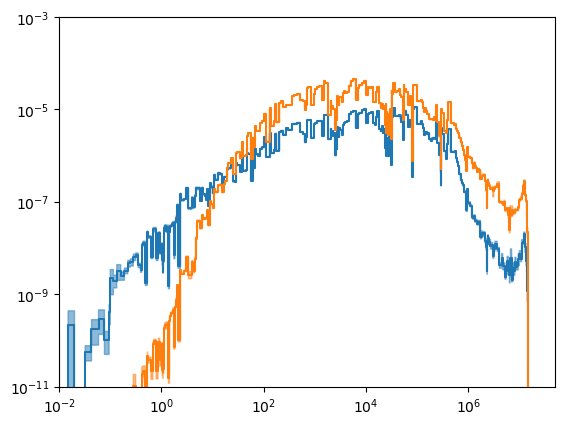

0.0005857045075208788 0.0021594204905854672


In [9]:
fig, ax = plt.subplots()
# ax.plot(hfir_ebins, hfir_spectrum, c='k', drawstyle='steps-pre')
ax.fill_between(ebins, iter_spectrum_mean - 1*iter_spectrum_stddev, iter_spectrum_mean + 1*iter_spectrum_stddev, step='pre', color='tab:blue', alpha=.5)
ax.plot(ebins, iter_spectrum_mean, c='tab:blue', drawstyle='steps-pre')
ax.fill_between(ebins, arc_spectrum_mean - 1*arc_spectrum_stddev, arc_spectrum_mean + 1*arc_spectrum_stddev, step='pre', color='tab:orange', alpha=.5)
ax.plot(ebins, arc_spectrum_mean, c='tab:orange', drawstyle='steps-pre')
ax.set_xlim(1e-2, 5e7)
ax.set_ylim(1e-11, 1e-3)
# ax.set_xlim(1e6, 2e7)
# ax.set_ylim(1e-5, 1e-3)
# ax.vlines(14.08e6, 1e-11, 1e-3)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
print(sum(iter_spectrum_mean), sum(arc_spectrum_mean))

/tmp/ipykernel_27491/1006810897.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
/tmp/ipykernel_27491/1006810897.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])


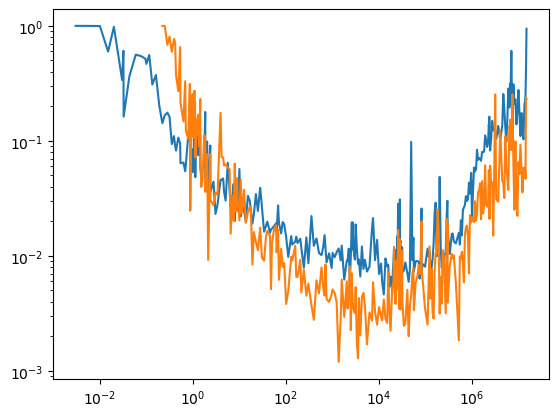

In [10]:
plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])

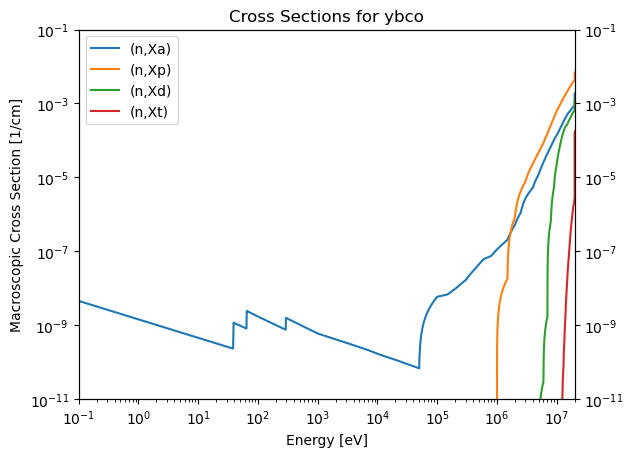

In [11]:
# Specify the materials you want to plot cross sections for
ybco = tre.materials.ybco
nb3sn = tre.materials.nb3sn

# Use openmc.plot_xs to create the cross section plots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
openmc.plot_xs(nb3sn, ['(n,Xa)', '(n,Xp)', '(n,Xd)', '(n,Xt)'], axis=ax1, c=['k', 'k','k','k'])
# openmc.plot_xs(ybco, ['(n,Xa)'], axis=ax1, c='k')
# ax2.plot(ebins, iter_tfcoil_spectrum.mean[:,0,0], lw=2, ls='-', c='k')
# ax2.plot(ebins, arc_tfcoil_spectrum.mean[:,0,0], lw=2, ls='--', c='k')
# ax2.plot(hfir_ebins, hfir_spectrum/sum(hfir_spectrum), lw=2, ls=':', c='k')
ax1.set_xlim(1e-1, 2e7), ax2.set_xlim(1e-1, 2e7)
ax1.set_ylim(1e-11, 1e-1), ax2.set_ylim(1e-11, 1e-1)
ax1.set_xscale('log'), ax2.set_xscale('log')
ax1.set_yscale('log'), ax2.set_yscale('log')
ax2.set_ylabel('')


plt.show()

In [12]:
reactions = ['(n,Xa)', '(n,Xp)', '(n,Xd)', '(n,Xt)']
E_hts, data_hts = openmc.calculate_cexs(ybco, reactions)
E_lts, data_lts = openmc.calculate_cexs(nb3sn, reactions)

[]

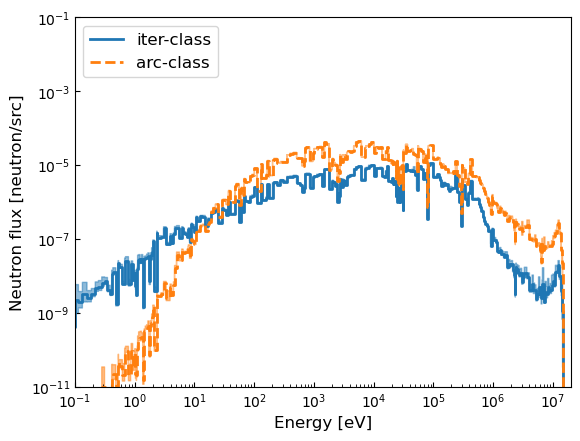

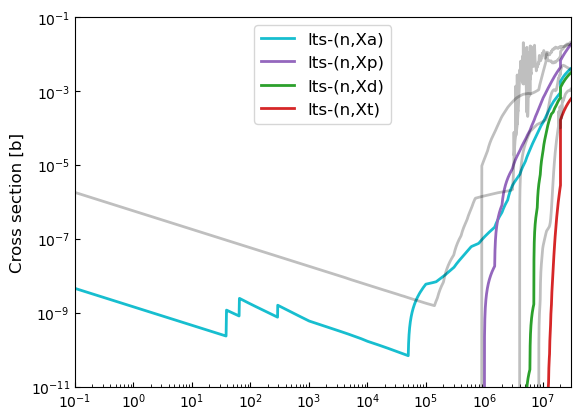

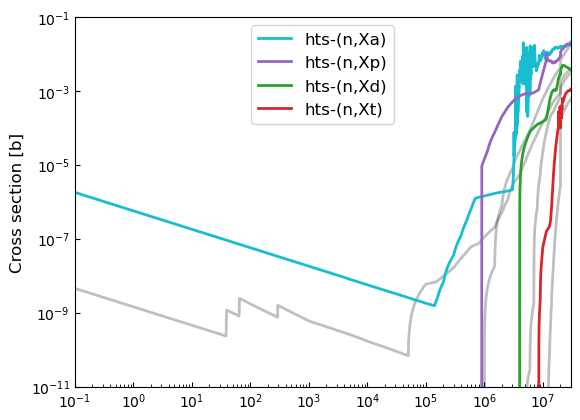

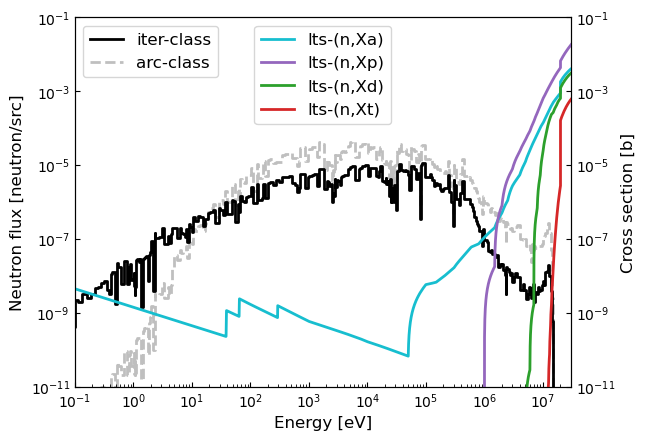

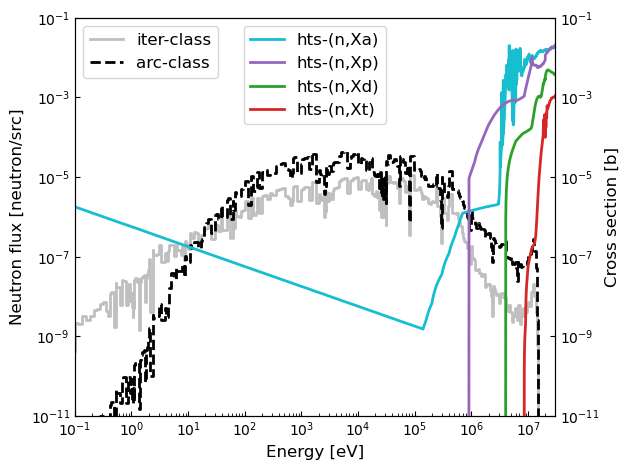

In [22]:
fig, ax = plt.subplots()
ax.fill_between(ebins, iter_spectrum_mean - 1*iter_spectrum_stddev, iter_spectrum_mean + 3*iter_spectrum_stddev, step='pre', color='tab:blue', alpha=.5)
ax.plot(ebins, iter_spectrum_mean, lw=2, ls='-', c='tab:blue', drawstyle='steps-pre', label='iter-class')
ax.fill_between(ebins, arc_spectrum_mean - 1*arc_spectrum_stddev, arc_spectrum_mean + 3*arc_spectrum_stddev, step='pre', color='tab:orange', alpha=.5)
ax.plot(ebins, arc_spectrum_mean, lw=2, ls='--', c='tab:orange', drawstyle='steps-pre', label='arc-class')
ax.set_xlim(1e-1, 2e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel('Energy [eV]', fontsize=12)
ax.set_ylabel('Neutron flux [neutron/src]', fontsize=12)

plt.plot()

fig, ax = plt.subplots()
ax.plot(E_lts, data_lts[0], lw=2, c='tab:cyan', label='lts-(n,Xa)')
ax.plot(E_lts, data_lts[1], lw=2, c='tab:purple', label='lts-(n,Xp)')
ax.plot(E_lts, data_lts[2], lw=2, c='tab:green', label='lts-(n,Xd)')
ax.plot(E_lts, data_lts[3], lw=2, c='tab:red', label='lts-(n,Xt)')
ax.plot(E_hts, data_hts[0], lw=2, c='k', alpha=.25, label='_hts-(n,Xa)')
ax.plot(E_hts, data_hts[1], lw=2, c='k', alpha=.25, label='_hts-(n,Xp)')
ax.plot(E_hts, data_hts[2], lw=2, c='k', alpha=.25, label='_hts-(n,Xd)')
ax.plot(E_hts, data_hts[3], lw=2, c='k', alpha=.25, label='_hts-(n,Xt)')
ax.set_xlim(1e-1, 3e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.set_ylabel('Cross section [b]', fontsize=12)
ax.legend(loc='upper center', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='y', which='minor', direction='in')
# fig.tight_layout()
plt.plot()

fig, ax = plt.subplots()
ax.plot(E_lts, data_lts[0], lw=2, c='k', alpha=.25, label='_lts-(n,Xa)')
ax.plot(E_lts, data_lts[1], lw=2, c='k', alpha=.25, label='_lts-(n,Xp)')
ax.plot(E_lts, data_lts[2], lw=2, c='k', alpha=.25, label='_lts-(n,Xd)')
ax.plot(E_lts, data_lts[3], lw=2, c='k', alpha=.25, label='_lts-(n,Xt)')
ax.plot(E_hts, data_hts[0], lw=2, c='tab:cyan', label='hts-(n,Xa)')
ax.plot(E_hts, data_hts[1], lw=2, c='tab:purple', label='hts-(n,Xp)')
ax.plot(E_hts, data_hts[2], lw=2, c='tab:green', label='hts-(n,Xd)')
ax.plot(E_hts, data_hts[3], lw=2, c='tab:red', label='hts-(n,Xt)')
ax.set_xlim(1e-1, 3e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.set_ylabel('Cross section [b]', fontsize=12)
ax.legend(loc='upper center', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='y', which='minor', direction='in')
# fig.tight_layout()
plt.plot()


fig, ax = plt.subplots()
ax.plot(ebins, iter_spectrum_mean, lw=2, ls='-', c='k', drawstyle='steps-pre', label='iter-class')
ax.plot(ebins, arc_spectrum_mean, lw=2, ls='--', c='k', alpha=.25, drawstyle='steps-pre', label='arc-class')
ax.set_xlim(1e-1, 3e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel('Energy [eV]', fontsize=12)
ax.set_ylabel('Neutron flux [neutron/src]', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax2 = ax.twinx()
ax2.plot(E_lts, data_lts[0], lw=2, c='tab:cyan', label='lts-(n,Xa)')
ax2.plot(E_lts, data_lts[1], lw=2, c='tab:purple', label='lts-(n,Xp)')
ax2.plot(E_lts, data_lts[2], lw=2, c='tab:green', label='lts-(n,Xd)')
ax2.plot(E_lts, data_lts[3], lw=2, c='tab:red', label='lts-(n,Xt)')
ax2.set_xlim(1e-1, 3e7), ax2.set_ylim(1e-11, 1e-1)
ax2.set_xscale('log'), ax2.set_yscale('log')
ax2.set_ylabel('Cross section [b]', fontsize=12)
ax2.legend(loc='upper center', fontsize=12)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.tick_params(axis='y', which='minor', direction='in')
# fig.tight_layout()
plt.plot()


fig, ax = plt.subplots()
ax.plot(ebins, iter_spectrum_mean, lw=2, ls='-', c='k', alpha=.25, drawstyle='steps-pre', label='iter-class')
ax.plot(ebins, arc_spectrum_mean, lw=2, ls='--', c='k', drawstyle='steps-pre', label='arc-class')
ax.set_xlim(1e-1, 3e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel('Energy [eV]', fontsize=12)
ax.set_ylabel('Neutron flux [neutron/src]', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax2 = ax.twinx()
ax2.plot(E_hts, data_hts[0], lw=2, c='tab:cyan', label='hts-(n,Xa)')
ax2.plot(E_hts, data_hts[1], lw=2, c='tab:purple', label='hts-(n,Xp)')
ax2.plot(E_hts, data_hts[2], lw=2, c='tab:green', label='hts-(n,Xd)')
ax2.plot(E_hts, data_hts[3], lw=2, c='tab:red', label='hts-(n,Xt)')
ax2.set_xlim(1e-1, 3e7), ax2.set_ylim(1e-11, 1e-1)
ax2.set_xscale('log'), ax2.set_yscale('log')
ax2.set_ylabel('Cross section [b]', fontsize=12)
ax2.legend(loc='upper center', fontsize=12)
ax2.tick_params(axis='both', which='both', direction='in')
plt.plot()

In [14]:
flux = iter_sp.get_tally(id=1)

mesh = flux.find_filter(openmc.MeshFilter).mesh

# writes the TBR mesh tally as a vtk file
mesh.write_data_to_vtk(
    filename="flux_map.vtk",
    datasets={"mean": flux.mean}  # the first "mean" is the name of the data set label inside the vtk file
)

<vtkmodules.vtkCommonDataModel.vtkStructuredGrid(0x55cfd3f29370) at 0x7ff1c2376140>

In [15]:
# Calculate for the CE cross sections
E, data = calculate_cexs(this, types, temperature, sab_name,
                            ce_cross_sections, enrichment)
if divisor_types:
    cv.check_length('divisor types', divisor_types, len(types))
    Ediv, data_div = calculate_cexs(this, divisor_types, temperature,
                                    sab_name, ce_cross_sections,
                                    enrichment)

    # Create a new union grid, interpolate data and data_div on to that
    # grid, and then do the actual division
    Enum = E[:]
    E = np.union1d(Enum, Ediv)
    data_new = np.zeros((len(types), len(E)))

    for line in range(len(types)):
        data_new[line, :] = \
            np.divide(np.interp(E, Enum, data[line, :]),
                        np.interp(E, Ediv, data_div[line, :]))
        if divisor_types[line] != 'unity':
            types[line] = types[line] + ' / ' + divisor_types[line]
    data = data_new

NameError: name 'calculate_cexs' is not defined